In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = "/content/drive/MyDrive/CV/brain_tumor_dataset"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
!pip install torch torchvision torch-geometric torchmetrics scikit-learn opencv-python tqdm
!pip install tensorflow==2.19.0 tensorflow-text tensorflow-decision-forests tf-keras
!pip install streamlit pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 36.7 MB/s eta 0:00:00


In [20]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import seaborn as sns
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool
import torch.nn as nn
from torchvision import models, transforms
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from PIL import Image
import networkx as nx
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [ ]:
preprocessed_dir = "/content/drive/MyDrive/CV/brain_tumor_dataset/preprocessed_brain_tumor_dataset"

os.makedirs(preprocessed_dir, exist_ok=True)
os.makedirs(os.path.join(preprocessed_dir, "yes"), exist_ok=True)
os.makedirs(os.path.join(preprocessed_dir, "no"), exist_ok=True)

def preprocess_image(img_path, target_size=(256, 256)):
    """
    Steps:
    1. Read and convert to grayscale
    2. Denoise with GaussianBlur
    3. Apply CLAHE for contrast enhancement
    4. Normalize and resize
    5. Return preprocessed image
    """
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Unable to read {img_path}")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(blur)

    resized = cv2.resize(enhanced, target_size)

    norm = resized / 255.0

    return norm

folders = ["yes", "no"]

for folder in folders:
    src_path = os.path.join(data_dir, folder)
    dest_path = os.path.join(preprocessed_dir, folder)
    os.makedirs(dest_path, exist_ok=True)

    for file in tqdm(os.listdir(src_path), desc=f"Processing {folder}"):
        try:
            img_path = os.path.join(src_path, file)
            processed = preprocess_image(img_path)

            processed_uint8 = (processed * 255).astype(np.uint8)
            save_path = os.path.join(dest_path, file)
            cv2.imwrite(save_path, processed_uint8)
        except Exception as e:
            print(f"Skipping {file}: {e}")

print("✅ Preprocessing complete! Saved in:", preprocessed_dir)

Processing no: 100%|██████████| 98/98 [02:00<00:00,  1.23s/it]

✅ Preprocessing complete! Saved in: /content/drive/MyDrive/Deep_Learning_Package/brain_tumor_dataset/preprocessed_brain_tumor_dataset


In [ ]:
sample_yes = os.path.join(data_dir, "yes", os.listdir(os.path.join(data_dir, "yes"))[0])
img_raw = cv2.imread(sample_yes, cv2.IMREAD_GRAYSCALE)
img_processed = preprocess_image(sample_yes)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.title("Original"); plt.imshow(img_raw, cmap="gray"); plt.axis('off')
plt.subplot(1,2,2); plt.title("Preprocessed"); plt.imshow(img_processed, cmap="gray"); plt.axis('off')
plt.show()


NameError: name 'os' is not defined

Data augmentation

In [ ]:
original_dir = "/content/drive/MyDrive/CV/brain_tumor_dataset/preprocessed_brain_tumor_dataset"
augmented_dir = "/content/drive/MyDrive/CV/brain_tumor_dataset/augmented_brain_tumor_dataset"

os.makedirs(augmented_dir, exist_ok=True)
for cls in os.listdir(original_dir):
    cls_path = os.path.join(augmented_dir, cls)
    os.makedirs(cls_path, exist_ok=True)

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

AUG_PER_IMAGE = 5

for cls in os.listdir(original_dir):
    input_folder = os.path.join(original_dir, cls)
    output_folder = os.path.join(augmented_dir, cls)

    print(f"\n🧠 Augmenting class: {cls}")
    for filename in tqdm(os.listdir(input_folder)):
        img_path = os.path.join(input_folder, filename)
        img = load_img(img_path)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        i = 0
        for batch in datagen.flow(
            x,
            batch_size=1,
            save_to_dir=output_folder,
            save_prefix=f"aug_{os.path.splitext(filename)[0]}",
            save_format='jpg'
        ):
            i += 1
            if i >= AUG_PER_IMAGE:
                break

print("\n✅ All augmented images saved successfully in:")
print(augmented_dir)



🧠 Augmenting class: yes


100%|██████████| 155/155 [00:35<00:00,  4.40it/s]



🧠 Augmenting class: no


100%|██████████| 98/98 [00:21<00:00,  4.48it/s]


✅ All augmented images saved successfully in:
/content/drive/MyDrive/Deep_Learning_Package/brain_tumor_dataset/augmented_brain_tumor_dataset


CNN - Feature extraction

✅ Combined dataset created at: /content/drive/MyDrive/Deep_Learning_Package/brain_tumor_dataset/combined_dataset
Found 5256 images belonging to 2 classes.
Found 1313 images belonging to 2 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
165/165 ━━━━━━━━━━━━━━━━━━━━ 1981s 12s/step - accuracy: 0.7730 - loss: 0.4785 - val_accuracy: 0.8591 - val_loss: 0.3111
Epoch 2/5
165/165 ━━━━━━━━━━━━━━━━━━━━ 32s 194ms/step - accuracy: 0.9560 - loss: 0.1399 - val_accuracy: 0.8865 - val_loss: 0.2766
Epoch 3/5
165/165 ━━━━━━━━━━━━━━━━━━━━ 34s 204ms/step - accuracy: 0.9869 - loss: 0.0731 - val_accuracy: 0.9018 - val_loss: 0.2680
Epoch 4/5
165/165 ━━━━━━━━━━━━━━━━━━━━ 35s 209ms/step - accuracy: 0.9962 - loss: 0.0379 - val_accuracy: 0.8919 - val_loss: 0.2588
Epoch 5/5
165/165 ━━━━━━━━━━━━━━━━━━━━ 34s 208ms/step - accuracy: 0.9977 - loss: 0.0240 - val_accuracy: 0.8979 - val_loss: 0.2835
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 188ms/step

🧾 Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.36      0.34      0.35       509
       Tumor       0.60      0.61      0.61       804

    accuracy                           0.51      1313
   macro avg       0.48      0.48      0.48      1313
weighted av

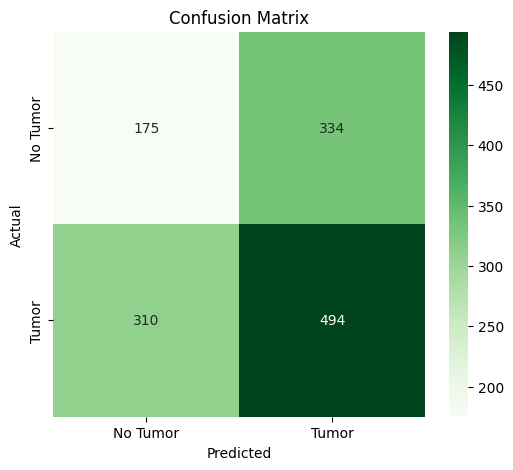

  0%|          | 0/165 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


  1%|          | 1/165 [00:00<02:27,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


  1%|          | 2/165 [00:01<01:32,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


  2%|▏         | 3/165 [00:01<01:16,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


  2%|▏         | 4/165 [00:01<01:07,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  3%|▎         | 5/165 [00:02<01:02,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


  4%|▎         | 6/165 [00:02<00:58,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


  4%|▍         | 7/165 [00:02<00:57,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  5%|▍         | 8/165 [00:03<00:56,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  5%|▌         | 9/165 [00:03<00:54,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  6%|▌         | 10/165 [00:03<00:53,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  7%|▋         | 11/165 [00:04<00:52,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


  7%|▋         | 12/165 [00:04<00:52,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


  8%|▊         | 13/165 [00:04<00:51,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


  8%|▊         | 14/165 [00:05<00:51,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


  9%|▉         | 15/165 [00:05<00:51,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 10%|▉         | 16/165 [00:06<00:50,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 10%|█         | 17/165 [00:06<00:55,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 11%|█         | 18/165 [00:06<00:54,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 12%|█▏        | 19/165 [00:07<00:53,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 12%|█▏        | 20/165 [00:07<00:55,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 13%|█▎        | 21/165 [00:08<01:00,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 13%|█▎        | 22/165 [00:08<00:58,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 14%|█▍        | 23/165 [00:08<00:57,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 15%|█▍        | 24/165 [00:09<00:55,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 15%|█▌        | 25/165 [00:09<00:55,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 16%|█▌        | 26/165 [00:09<00:53,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 16%|█▋        | 27/165 [00:10<00:51,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 17%|█▋        | 28/165 [00:10<00:49,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 18%|█▊        | 29/165 [00:11<00:47,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 18%|█▊        | 30/165 [00:11<00:47,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 19%|█▉        | 31/165 [00:11<00:46,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 19%|█▉        | 32/165 [00:12<00:46,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 20%|██        | 33/165 [00:12<00:45,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 21%|██        | 34/165 [00:12<00:45,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 21%|██        | 35/165 [00:13<00:45,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 22%|██▏       | 36/165 [00:13<00:45,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 22%|██▏       | 37/165 [00:13<00:44,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 23%|██▎       | 38/165 [00:14<00:43,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 24%|██▎       | 39/165 [00:14<00:43,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 24%|██▍       | 40/165 [00:14<00:42,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 25%|██▍       | 41/165 [00:15<00:42,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 25%|██▌       | 42/165 [00:15<00:41,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 26%|██▌       | 43/165 [00:15<00:41,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 27%|██▋       | 44/165 [00:16<00:40,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 27%|██▋       | 45/165 [00:16<00:40,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 28%|██▊       | 46/165 [00:16<00:40,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 28%|██▊       | 47/165 [00:17<00:40,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 29%|██▉       | 48/165 [00:17<00:39,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 30%|██▉       | 49/165 [00:17<00:39,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 30%|███       | 50/165 [00:18<00:39,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 31%|███       | 51/165 [00:18<00:38,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 32%|███▏      | 52/165 [00:18<00:38,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 32%|███▏      | 53/165 [00:19<00:37,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 33%|███▎      | 54/165 [00:19<00:37,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 33%|███▎      | 55/165 [00:20<00:41,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 34%|███▍      | 56/165 [00:20<00:41,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 35%|███▍      | 57/165 [00:20<00:40,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 35%|███▌      | 58/165 [00:21<00:45,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 36%|███▌      | 59/165 [00:21<00:43,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 36%|███▋      | 60/165 [00:22<00:41,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 37%|███▋      | 61/165 [00:22<00:45,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 38%|███▊      | 62/165 [00:22<00:41,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 38%|███▊      | 63/165 [00:23<00:40,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 39%|███▉      | 64/165 [00:23<00:37,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 39%|███▉      | 65/165 [00:23<00:36,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 40%|████      | 66/165 [00:24<00:35,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 41%|████      | 67/165 [00:24<00:35,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 41%|████      | 68/165 [00:24<00:33,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 42%|████▏     | 69/165 [00:25<00:33,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 42%|████▏     | 70/165 [00:25<00:32,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 43%|████▎     | 71/165 [00:26<00:32,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 44%|████▎     | 72/165 [00:26<00:32,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 44%|████▍     | 73/165 [00:26<00:32,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 45%|████▍     | 74/165 [00:27<00:31,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 45%|████▌     | 75/165 [00:27<00:31,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 46%|████▌     | 76/165 [00:27<00:31,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 47%|████▋     | 77/165 [00:28<00:30,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 47%|████▋     | 78/165 [00:28<00:30,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 48%|████▊     | 79/165 [00:28<00:29,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 48%|████▊     | 80/165 [00:29<00:29,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 49%|████▉     | 81/165 [00:29<00:29,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 50%|████▉     | 82/165 [00:29<00:28,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 50%|█████     | 83/165 [00:30<00:28,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 51%|█████     | 84/165 [00:30<00:27,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 52%|█████▏    | 85/165 [00:30<00:27,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 52%|█████▏    | 86/165 [00:31<00:27,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 53%|█████▎    | 87/165 [00:31<00:27,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 53%|█████▎    | 88/165 [00:31<00:27,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 54%|█████▍    | 89/165 [00:32<00:26,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 55%|█████▍    | 90/165 [00:32<00:29,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 55%|█████▌    | 91/165 [00:33<00:31,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 56%|█████▌    | 92/165 [00:33<00:33,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 56%|█████▋    | 93/165 [00:34<00:31,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 57%|█████▋    | 94/165 [00:34<00:29,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 58%|█████▊    | 95/165 [00:35<00:31,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 58%|█████▊    | 96/165 [00:35<00:28,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 59%|█████▉    | 97/165 [00:35<00:27,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 59%|█████▉    | 98/165 [00:36<00:25,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 60%|██████    | 99/165 [00:36<00:24,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 61%|██████    | 100/165 [00:36<00:24,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 61%|██████    | 101/165 [00:37<00:22,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 62%|██████▏   | 102/165 [00:37<00:22,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 62%|██████▏   | 103/165 [00:37<00:22,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 63%|██████▎   | 104/165 [00:38<00:21,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 64%|██████▎   | 105/165 [00:38<00:20,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 64%|██████▍   | 106/165 [00:38<00:20,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 65%|██████▍   | 107/165 [00:39<00:20,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 65%|██████▌   | 108/165 [00:39<00:20,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 66%|██████▌   | 109/165 [00:40<00:19,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 67%|██████▋   | 110/165 [00:40<00:19,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 67%|██████▋   | 111/165 [00:40<00:19,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 68%|██████▊   | 112/165 [00:41<00:19,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 68%|██████▊   | 113/165 [00:41<00:18,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 69%|██████▉   | 114/165 [00:41<00:18,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 70%|██████▉   | 115/165 [00:42<00:17,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 70%|███████   | 116/165 [00:42<00:17,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 71%|███████   | 117/165 [00:42<00:17,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 72%|███████▏  | 118/165 [00:43<00:16,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 72%|███████▏  | 119/165 [00:43<00:16,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 73%|███████▎  | 120/165 [00:43<00:15,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 73%|███████▎  | 121/165 [00:44<00:15,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 74%|███████▍  | 122/165 [00:44<00:14,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 75%|███████▍  | 123/165 [00:44<00:14,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 75%|███████▌  | 124/165 [00:45<00:14,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 76%|███████▌  | 125/165 [00:45<00:14,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 76%|███████▋  | 126/165 [00:46<00:14,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 77%|███████▋  | 127/165 [00:46<00:14,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 78%|███████▊  | 128/165 [00:46<00:14,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 78%|███████▊  | 129/165 [00:47<00:13,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 79%|███████▉  | 130/165 [00:47<00:14,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 79%|███████▉  | 131/165 [00:48<00:13,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 80%|████████  | 132/165 [00:48<00:12,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 81%|████████  | 133/165 [00:48<00:12,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 81%|████████  | 134/165 [00:49<00:11,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 82%|████████▏ | 135/165 [00:49<00:10,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 82%|████████▏ | 136/165 [00:49<00:10,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 83%|████████▎ | 137/165 [00:50<00:09,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 84%|████████▎ | 138/165 [00:50<00:09,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 84%|████████▍ | 139/165 [00:50<00:09,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 85%|████████▍ | 140/165 [00:51<00:08,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 85%|████████▌ | 141/165 [00:51<00:08,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 86%|████████▌ | 142/165 [00:51<00:07,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 87%|████████▋ | 143/165 [00:52<00:07,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 87%|████████▋ | 144/165 [00:52<00:07,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 88%|████████▊ | 145/165 [00:53<00:07,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 88%|████████▊ | 146/165 [00:53<00:06,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 89%|████████▉ | 147/165 [00:53<00:06,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 90%|████████▉ | 148/165 [00:54<00:05,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 90%|█████████ | 149/165 [00:54<00:05,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 91%|█████████ | 150/165 [00:54<00:05,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 92%|█████████▏| 151/165 [00:55<00:04,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 92%|█████████▏| 152/165 [00:55<00:04,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 93%|█████████▎| 153/165 [00:55<00:04,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 93%|█████████▎| 154/165 [00:56<00:03,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 94%|█████████▍| 155/165 [00:56<00:03,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 95%|█████████▍| 156/165 [00:56<00:03,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 95%|█████████▌| 157/165 [00:57<00:02,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 96%|█████████▌| 158/165 [00:57<00:02,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 96%|█████████▋| 159/165 [00:57<00:02,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 97%|█████████▋| 160/165 [00:58<00:02,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 98%|█████████▊| 161/165 [00:58<00:01,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 98%|█████████▊| 162/165 [00:59<00:01,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 99%|█████████▉| 163/165 [01:00<00:00,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 99%|█████████▉| 164/165 [01:00<00:00,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


  0%|          | 0/42 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


  2%|▏         | 1/42 [00:00<00:14,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


  5%|▍         | 2/42 [00:00<00:14,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


  7%|▋         | 3/42 [00:01<00:13,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 10%|▉         | 4/42 [00:01<00:13,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 12%|█▏        | 5/42 [00:01<00:12,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 14%|█▍        | 6/42 [00:02<00:12,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 17%|█▋        | 7/42 [00:02<00:12,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 19%|█▉        | 8/42 [00:02<00:12,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 21%|██▏       | 9/42 [00:03<00:11,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 24%|██▍       | 10/42 [00:03<00:11,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 26%|██▌       | 11/42 [00:03<00:10,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 29%|██▊       | 12/42 [00:04<00:10,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 31%|███       | 13/42 [00:04<00:10,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 33%|███▎      | 14/42 [00:04<00:10,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 36%|███▌      | 15/42 [00:05<00:09,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 38%|███▊      | 16/42 [00:05<00:09,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 40%|████      | 17/42 [00:06<00:08,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 43%|████▎     | 18/42 [00:06<00:08,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 45%|████▌     | 19/42 [00:06<00:08,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 48%|████▊     | 20/42 [00:07<00:07,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 50%|█████     | 21/42 [00:07<00:07,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 52%|█████▏    | 22/42 [00:07<00:07,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 55%|█████▍    | 23/42 [00:08<00:06,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 57%|█████▋    | 24/42 [00:08<00:06,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 60%|█████▉    | 25/42 [00:08<00:05,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 62%|██████▏   | 26/42 [00:09<00:05,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 64%|██████▍   | 27/42 [00:09<00:05,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 67%|██████▋   | 28/42 [00:10<00:05,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 69%|██████▉   | 29/42 [00:10<00:05,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 71%|███████▏  | 30/42 [00:11<00:05,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 74%|███████▍  | 31/42 [00:11<00:05,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 76%|███████▌  | 32/42 [00:12<00:04,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 79%|███████▊  | 33/42 [00:12<00:03,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 81%|████████  | 34/42 [00:12<00:03,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 83%|████████▎ | 35/42 [00:13<00:02,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 86%|████████▌ | 36/42 [00:13<00:02,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 88%|████████▊ | 37/42 [00:13<00:01,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 90%|█████████ | 38/42 [00:14<00:01,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 93%|█████████▎| 39/42 [00:14<00:01,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 95%|█████████▌| 40/42 [00:14<00:00,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 98%|█████████▊| 41/42 [00:15<00:00,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 98%|█████████▊| 41/42 [00:15<00:00,  2.62it/s]



✅ CNN features extracted and saved successfully!
Train feature shape: (5256, 7, 7, 512)
Validation feature shape: (1313, 7, 7, 512)


In [ ]:
#Combine Preprocessed + Augmented Dataset
pre_dir = "/content/drive/MyDrive/CV/brain_tumor_dataset/preprocessed_brain_tumor_dataset"
aug_dir = "/content/drive/MyDrive/CV/brain_tumor_dataset/augmented_brain_tumor_dataset"
combined_dir = "/content/drive/MyDrive/CV/brain_tumor_dataset/combined_dataset"

os.makedirs(combined_dir, exist_ok=True)
for cls in os.listdir(pre_dir):
    os.makedirs(os.path.join(combined_dir, cls), exist_ok=True)
    for src_dir in [pre_dir, aug_dir]:
        src_path = os.path.join(src_dir, cls)
        for img_name in os.listdir(src_path):
            src_img = os.path.join(src_path, img_name)
            dst_img = os.path.join(combined_dir, cls, img_name)
            if not os.path.exists(dst_img):
                os.system(f'cp "{src_img}" "{dst_img}"')

print("✅ Combined dataset created at:", combined_dir)

#Load Images using ImageDataGenerator
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    combined_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    combined_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

#Build CNN Model using VGG16 as Feature Extractor
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

#Freeze pretrained layers
for layer in base_model.layers:
    layer.trainable = False

#Add custom layers
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

#Train Model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=[early_stop],
    verbose=1
)
#Evaluate Model
val_gen.reset()
preds = model.predict(val_gen, verbose=1)
y_pred = (preds > 0.5).astype(int).ravel()
y_true = val_gen.classes

print("\n🧾 Classification Report:")
print(classification_report(y_true, y_pred, target_names=['No Tumor', 'Tumor']))

#Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['No Tumor','Tumor'], yticklabels=['No Tumor','Tumor'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#Extract and Save CNN Features
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

def extract_features(generator, feature_model):
    features, labels = [], []
    for batch_imgs, batch_labels in tqdm(generator, total=len(generator)):
        feats = feature_model.predict(batch_imgs)
        features.append(feats)
        labels.append(batch_labels)
        if len(features) >= len(generator):
            break
    return np.concatenate(features), np.concatenate(labels)

train_gen.reset()
val_gen.reset()
train_features, train_labels = extract_features(train_gen, feature_extractor)
val_features, val_labels = extract_features(val_gen, feature_extractor)

os.makedirs("/content/drive/MyDrive/CV/features", exist_ok=True)
np.save("/content/drive/MyDrive/CV/features/train_features.npy", train_features)
np.save("/content/drive/MyDrive/CV/features/train_labels.npy", train_labels)
np.save("/content/drive/MyDrive/CV/features/val_features.npy", val_features)
np.save("/content/drive/MyDrive/CV/features/val_labels.npy", val_labels)

print("\nCNN features extracted and saved successfully!")
print("Train feature shape:", train_features.shape)
print("Validation feature shape:", val_features.shape)


GNN for classification


In [ ]:
#Load CNN features and labels (saved from your earlier step)
train_feats = np.load("/content/drive/MyDrive/CV/features/train_features.npy")
train_labels = np.load("/content/drive/MyDrive/CV/features/train_labels.npy")
val_feats   = np.load("/content/drive/MyDrive/CV/features/val_features.npy")
val_labels   = np.load("/content/drive/MyDrive/CV/features/val_labels.npy")

#construct graph(s) – for simplicity assume each image becomes one graph, or patches become nodes in a single graph
# Example: treat each “image” as a graph: nodes = patches & their feature vectors, edges based on spatial/feature similarity
def build_graph(features_array):
    #Flatten 3D CNN feature map (H, W, C) → (N, C)
    if features_array.ndim == 3:
        features_array = features_array.reshape(-1, features_array.shape[-1])

    x = torch.tensor(features_array, dtype=torch.float)
    num_nodes = x.size(0)

    #Simple fully connected graph
    edge_index = torch.tensor(
        [[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j],
        dtype=torch.long
    ).t().contiguous()

    return Data(x=x, edge_index=edge_index)


#Build train and validation graphs
train_graphs = [build_graph(feats) for feats in train_feats]
for i, g in enumerate(train_graphs):
    g.y = torch.tensor([int(train_labels[i])], dtype=torch.long)
val_graphs   = [build_graph(feats) for feats in val_feats]
for i, g in enumerate(val_graphs):
    g.y = torch.tensor([int(val_labels[i])], dtype=torch.long)

train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_graphs,   batch_size=32, shuffle=False)

#Define GCN Model
class GCNNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNNet, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return F.log_softmax(x, dim=1)

#Define GAT Model
class GATNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4):
        super(GATNet, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=1, concat=False)
        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return F.log_softmax(x, dim=1)

#Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GATNet(in_channels=train_feats.shape[-1], hidden_channels=64, out_channels=2).to(device)  # or use GCNNet
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.NLLLoss()

for epoch in range(1, 101):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch:03d}, Loss: {total_loss:.4f}")

    #Validation
    model.eval()
    correct = 0
    total   = 0
    for data in val_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        total   += data.y.size(0)
    acc = correct / total
    print(f"Validation Accuracy: {acc:.4f}")

#Save trained GNN model
save_path = "/content/drive/MyDrive/CV/saved_models/gnn_brain_tumor_model.pth"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
torch.save(model.state_dict(), save_path)
print(f"✅ GNN Model saved at: {save_path}")

Epoch 001, Loss: 53.0418
Validation Accuracy: 0.8934
Epoch 002, Loss: 11.4887
Validation Accuracy: 0.8271
Epoch 003, Loss: 8.0802
Validation Accuracy: 0.8507
Epoch 004, Loss: 4.9090
Validation Accuracy: 0.8759
Epoch 005, Loss: 7.2364
Validation Accuracy: 0.8370
Epoch 006, Loss: 5.6917
Validation Accuracy: 0.8926
Epoch 007, Loss: 4.0982
Validation Accuracy: 0.8804
Epoch 008, Loss: 5.0223
Validation Accuracy: 0.8911
Epoch 009, Loss: 5.1275
Validation Accuracy: 0.8819
Epoch 010, Loss: 6.2045
Validation Accuracy: 0.8835
Epoch 011, Loss: 1.9454
Validation Accuracy: 0.8880
Epoch 012, Loss: 6.1267
Validation Accuracy: 0.8781
Epoch 013, Loss: 2.3359
Validation Accuracy: 0.8850
Epoch 014, Loss: 0.4770
Validation Accuracy: 0.8789
Epoch 015, Loss: 5.9481
Validation Accuracy: 0.8644
Epoch 016, Loss: 3.2478
Validation Accuracy: 0.9078
Epoch 017, Loss: 4.1484
Validation Accuracy: 0.8469
Epoch 018, Loss: 1.3548
Validation Accuracy: 0.8880
Epoch 019, Loss: 0.1245
Validation Accuracy: 0.8896
Epoch 020,

GNN visualization output

🧾 Classification Report (CNN + GNN Model):
              precision    recall  f1-score   support

    No Tumor     0.9116    0.8310    0.8695       509
       Tumor     0.8987    0.9490    0.9232       804

    accuracy                         0.9033      1313
   macro avg     0.9052    0.8900    0.8963      1313
weighted avg     0.9037    0.9033    0.9024      1313



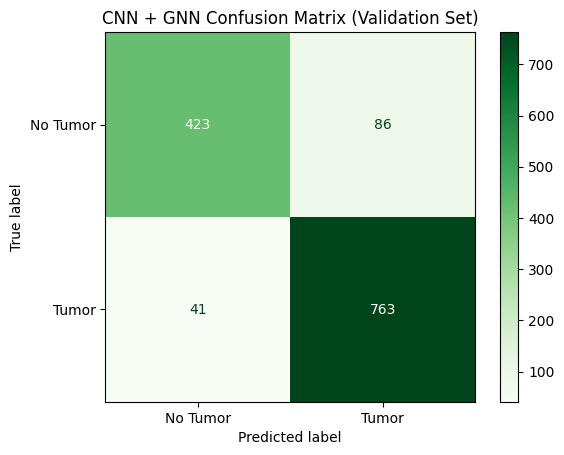

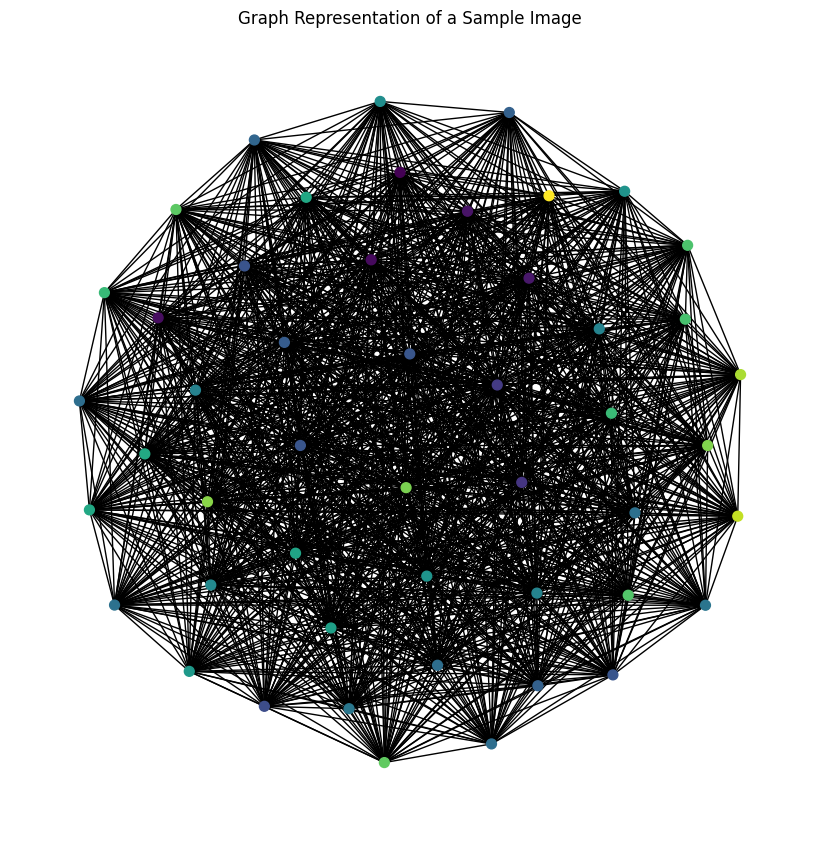

Tumor probability for the sample graph: 0.00%


In [ ]:
model.eval()
y_true, y_pred = [], []

for data in val_loader:
    data = data.to(device)
    with torch.no_grad():
        out = model(data.x, data.edge_index, data.batch)
        preds = out.argmax(dim=1)
    y_true.extend(data.y.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())

print("🧾 Classification Report (CNN + GNN Model):")
print(classification_report(
    y_true,
    y_pred,
    target_names=["No Tumor", "Tumor"],
    digits=4
))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["No Tumor", "Tumor"])
disp.plot(cmap="Greens")
plt.title("CNN + GNN Confusion Matrix (Validation Set)")
plt.show()

G = nx.Graph()
sample_data = next(iter(val_loader)).to(device)
x_sample = sample_data.x
edge_index_sample = sample_data.edge_index
batch_sample = sample_data.batch

nodes_in_first_graph = (batch_sample == 0).nonzero(as_tuple=False).squeeze()

G = nx.Graph()
if nodes_in_first_graph.ndim == 0:
    x_first_graph = x_sample[nodes_in_first_graph].unsqueeze(0)
    node_map = {nodes_in_first_graph.item(): 0}
else:
    x_first_graph = x_sample[nodes_in_first_graph]
    node_map = {old_idx.item(): new_idx for new_idx, old_idx in enumerate(nodes_in_first_graph)}


#Need to re-index edge_index for the subgraph
edge_index_first_graph = edge_index_sample[:, (batch_sample[edge_index_sample[0]] == 0) & (batch_sample[edge_index_sample[1]] == 0)]
#Re-index node indices in edge_index
edge_index_first_graph_reindexed = torch.tensor([[node_map[int(u)], node_map[int(v)]] for u, v in edge_index_first_graph.t().tolist()], dtype=torch.long).t().contiguous()


for i in range(x_first_graph.size(0)):
    G.add_node(i, feature=x_first_graph[i].sum().item())


for i, j in edge_index_first_graph_reindexed.t().tolist():
    G.add_edge(i, j)

plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)
node_features = [G.nodes[n]['feature'] for n in G.nodes]
nx.draw(G, pos, node_color=node_features, cmap=plt.cm.viridis, with_labels=False, node_size=50)
plt.title("Graph Representation of a Sample Image")
plt.show()

model.eval()
with torch.no_grad():
    single_sample_out = model(sample_data.x, sample_data.edge_index, sample_data.batch)
    prob = torch.exp(single_sample_out)  # since using log_softmax

#Assuming binary classification, prob[0, 1] is the probability of the positive class (Tumor)
print(f"Tumor probability for the sample graph: {prob[0,1]*100:.2f}%")

prediction with ui

ngrok auth connection tot external link

In [39]:
%%writefile app.py
import streamlit as st
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.models import vgg16, VGG16_Weights
from torch_geometric.data import Data
from torch_geometric.nn import GATConv, global_mean_pool
from PIL import Image
import numpy as np
import cv2

#CNN Feature Extractor (from VGG16)
class CNNFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        base_model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
        self.features = nn.Sequential(*list(base_model.features.children())[:-1])

    def forward(self, x):
        with torch.no_grad():
            x = self.features(x)
            x = F.adaptive_avg_pool2d(x, (7,7))
        return x

#GNN (GAT) Model
class GATNet(nn.Module):
    def __init__(self, in_channels=512, hidden_channels=64, out_channels=2, heads=4):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels*heads, hidden_channels, heads=1, concat=False)
        self.lin = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return F.log_softmax(x, dim=1)

#Preprocessing
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

#Graph builder (8 neighbors)
def build_graph_from_features(features):
    _, C, H, W = features.shape
    x = features.view(C, H*W).T
    edge_list = []
    for i in range(H):
        for j in range(W):
            idx = i*W + j
            for di in [-1,0,1]:
                for dj in [-1,0,1]:
                    if di==0 and dj==0: continue
                    ni, nj = i+di, j+dj
                    if 0<=ni<H and 0<=nj<W:
                        edge_list.append([idx, ni*W+nj])
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    batch = torch.zeros(H*W, dtype=torch.long)
    return Data(x=x, edge_index=edge_index, batch=batch)

#Initialize CNN and GNN
cnn_extractor = CNNFeatureExtractor().eval()
gnn_model = GATNet(in_channels=512, hidden_channels=64, out_channels=2).eval()
# =====================================
# 🔹 Grad-CAM for Region Highlighting
# =====================================
class GradCAM:
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.activations = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward_hook(self, module, input, output):
        self.activations = output
        output.register_hook(self.save_gradient)

    def generate_cam(self, input_image, target_class):
        #Register hook on last conv layer
        handle = self.model.features[-1].register_forward_hook(self.forward_hook)

        #Forward pass
        features = self.model.features(input_image)
        features = F.adaptive_avg_pool2d(features, (7,7))

        #Backward pass
        features.sum().backward()

        #Generate CAM
        gradients = self.gradients.detach()
        activations = self.activations.detach()

        weights = gradients.mean(dim=(2,3), keepdim=True)
        cam = (weights * activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=(224,224), mode='bilinear')
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        handle.remove()
        return cam.squeeze().cpu().numpy()

#Initialize Grad-CAM
grad_cam = GradCAM(cnn_extractor)

def predict_tumor(image):
    if image.mode != "RGB":
        image = image.convert("RGB")
    img_t = transform(image).unsqueeze(0)
    img_t.requires_grad = True

    #Extract CNN features
    feats = cnn_extractor(img_t)

    #Build graph for GNN
    data = build_graph_from_features(feats)

    #Predict using GNN
    with torch.no_grad():
        out = gnn_model(data.x, data.edge_index, data.batch)
        probs = F.softmax(out, dim=1)
        pred = torch.argmax(probs, dim=1).item()

    label = "No Tumor" if pred==0 else "Tumor"
    confidence = probs[0,pred].item()

    #Generate heatmap if tumor detected
    heatmap = None
    if pred == 1:
        cnn_extractor.train()
        heatmap = grad_cam.generate_cam(img_t, target_class=1)
        cnn_extractor.eval()

    return label, confidence, heatmap

def get_tumor_contour(heatmap, threshold=0.5):
    import cv2

    #Threshold the heatmap
    binary_mask = (heatmap > threshold).astype(np.uint8) * 255

    #Find contours
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return None

    #Get the largest contour (assumed to be tumor)
    largest_contour = max(contours, key=cv2.contourArea)
    return largest_contour

def draw_tumor_circle(image, heatmap, threshold=0.5):
    #Resize image to 224x224 for alignment
    img_resized = image.resize((224, 224))
    img_np = np.array(img_resized)

    #Get tumor contour
    contour = get_tumor_contour(heatmap, threshold)

    if contour is None:
        return img_resized

    #Get bounding circle
    (x, y), radius = cv2.minEnclosingCircle(contour)
    center = (int(x), int(y))
    radius = int(radius)

    #Draw circle on image
    img_with_circle = img_np.copy()
    cv2.circle(img_with_circle, center, radius, (255, 0, 0), 3)

    cv2.drawMarker(img_with_circle, center, (255, 0, 0), cv2.MARKER_CROSS, 15, 2)

    return Image.fromarray(img_with_circle)

#Streamlit UI
st.set_page_config(page_title="Brain Tumor Detector", page_icon="🧠", layout="wide")
st.title("Brain Tumor Detection using CNN + GNN")
st.markdown("Upload an MRI image to detect Tumor / No Tumor.")

uploaded_file = st.file_uploader("Upload MRI Image", type=["jpg","jpeg","png"])
if uploaded_file:
    img = Image.open(uploaded_file)
    col1, col2 = st.columns(2)

    with col1:
        st.image(img, caption="Original Image", use_container_width=True)

    if st.button("Predict"):
        with st.spinner("Analyzing image..."):
            label, confidence, heatmap = predict_tumor(img)

        if label=="No Tumor":
            st.success(f"{label}")
        else:
            st.error(f"{label}")

            #Show tumor region with circle
            if heatmap is not None:
                with col2:
                    circled_img = draw_tumor_circle(img, heatmap, threshold=0.5)
                    st.image(circled_img, caption="Tumor Region Encircled", use_container_width=True)


Overwriting app.py


In [ ]:
!pip install streamlit pyngrok torch torchvision torch-geometric -q

import os
import threading
import time
from pyngrok import ngrok

NGROK_AUTH_TOKEN = ""
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

ngrok.kill()

def run_streamlit():
    os.system("streamlit run app.py --server.port 8501 --server.headless true")

thread = threading.Thread(target=run_streamlit)
thread.start()

time.sleep(5)

public_url = ngrok.connect(8501, bind_tls=True)
print("Streamlit is live! Access it here:\n")
print(public_url.public_url)


Streamlit is live! Access it here:

https://4caa4fa95de8.ngrok-free.app
